In [ ]:
# Imported necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:

# We load the dataset and print the data information
data = pd.read_csv("dataset_assignment1.csv")
print("Data Information:")
data.info()


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   feature1  700 non-null    int64
 1   feature2  700 non-null    int64
 2   feature3  700 non-null    int64
 3   feature4  700 non-null    int64
 4   feature5  700 non-null    int64
 5   feature6  700 non-null    int64
 6   feature7  700 non-null    int64
 7   feature8  700 non-null    int64
 8   feature9  700 non-null    int64
 9   class     700 non-null    int64
dtypes: int64(10)
memory usage: 54.8 KB


In [ ]:

# We print few samples of the data to check how data looks like
print("Few samples of the data:")
data.head()

Few samples of the data:


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0



Number of samples for each class:
0    459
1    241
Name: class, dtype: int64


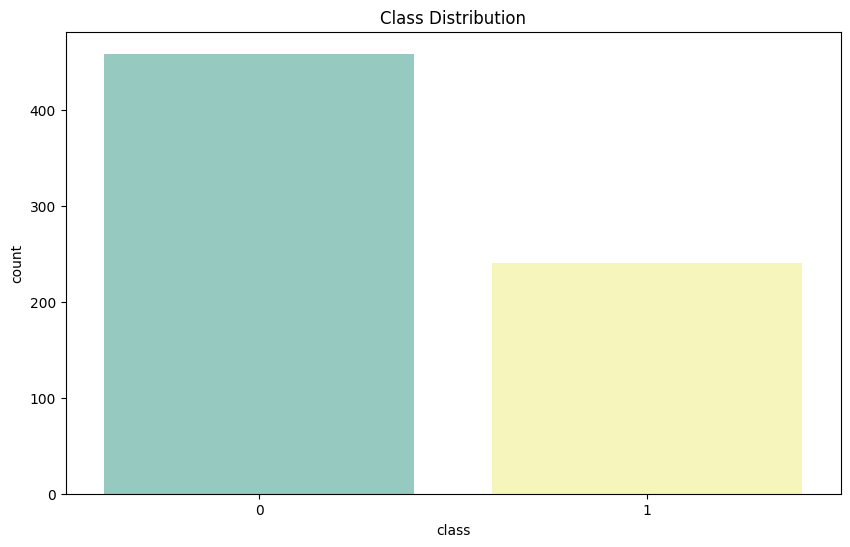

In [ ]:
print("\nNumber of samples for each class:")
print(data['class'].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='class', hue='class', data=data, palette='Set3', legend=False)
plt.title("Class Distribution")
plt.show()


In [ ]:
for class_label in data['class'].unique():
    print("\n" + "="*50)  # Add a separator line
    print("\033[1mStatistical Description of Features for Class:", class_label, "\033[0m")  # Bold text
    class_data = data[data['class'] == class_label].drop('class', axis=1)
    class_description = class_data.describe()
    print(class_description.to_string())



Statistical Description of Features for Class: 0 
         feature1    feature2    feature3    feature4    feature5    feature6    feature7    feature8    feature9
count  459.000000  459.000000  459.000000  459.000000  459.000000  459.000000  459.000000  459.000000  459.000000
mean     2.956427    1.324619    1.442266    1.363834    2.119826    1.437908    2.102397    1.289760    1.063181
std      1.672490    0.906830    0.996960    0.995886    0.916145    1.310839    1.079976    1.057787    0.501456
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000
25%      1.000000    1.000000    1.000000    1.000000    2.000000    1.000000    1.000000    1.000000    1.000000
50%      3.000000    1.000000    1.000000    1.000000    2.000000    1.000000    2.000000    1.000000    1.000000
75%      4.000000    1.000000    1.000000    1.000000    2.000000    1.000000    3.000000    1.000000    1.000000
max      8.000000    9.000000    8.00

In [ ]:
# Step 4: We split data into training and testing datasets as 80% v.s. 20%
X = data.drop('class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Here we print the shapes to verify the split
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (560, 9) (560,)
Testing set shape: (140, 9) (140,)


In [ ]:
def model_design(model, hyperparameters, X_train, y_train, X_test, y_test):
    """Model design and evaluation"""
    # Standardizing the features by removing the mean and scaling to unit variance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # We are doing Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(model, hyperparameters, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], refit=False)
    grid_search.fit(X_train_scaled, y_train)

    # Extracting the scores for each parameter set
    params = grid_search.cv_results_['params']
    accuracy_scores = grid_search.cv_results_['mean_test_accuracy']
    precision_scores = grid_search.cv_results_['mean_test_precision_macro']
    recall_scores = grid_search.cv_results_['mean_test_recall_macro']
    f1_scores = grid_search.cv_results_['mean_test_f1_macro']

    # Combining the scores and parameters into a DataFrame
    results_df = pd.DataFrame({'params': params,
                               'accuracy': accuracy_scores,
                               'precision': precision_scores,
                               'recall': recall_scores,
                               'f1': f1_scores})

    # Finding the top 4 rows based on each metric for the current model
    top_accuracy = results_df.nlargest(5, 'accuracy')
    top_precision = results_df.nlargest(5, 'precision')
    top_recall = results_df.nlargest(5, 'recall')
    top_f1 = results_df.nlargest(5, 'f1')

    # Storing results for the current model in a dictionary
    model_results = {'accuracy': top_accuracy, 'precision': top_precision, 'recall': top_recall, 'f1': top_f1}

    return model_results

def plot_learning_curve(model, model_name, X, y):
    plt.figure(figsize=(9, 5))
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation Score')
    plt.title(f'Learning Curve - {model_name}')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:

# Defining hyperparameters for each model
knn_hyperparameters = {'n_neighbors': [5, 6, 7, 8, 9]}
svm_hyperparameters = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly']}
rf_hyperparameters = {'n_estimators': [50, 100, 150], 'max_depth': [20, 30, 40]}


In [ ]:
# Model design and evaluation for KNN
knn_results = model_design(KNeighborsClassifier(), knn_hyperparameters, X_train, y_train, X_test, y_test)
# Displaying the top scores for KNN model
print("Top KNN Scores:")
knn_results['accuracy']


Top KNN Scores:


,params,accuracy,precision,recall,f1
2,{'n_neighbors': 7},0.964286,0.960765,0.960660,0.960632
3,{'n_neighbors': 8},0.964286,0.960765,0.960660,0.960632
4,{'n_neighbors': 9},0.962500,0.958310,0.959290,0.958700
1,{'n_neighbors': 6},0.960714,0.957909,0.955532,0.956600
0,{'n_neighbors': 5},0.958929,0.955455,0.954162,0.954668


In [ ]:
# Model design and evaluation for Random Forest
rf_results = model_design(RandomForestClassifier(), rf_hyperparameters, X_train, y_train, X_test, y_test)
# Displaying the top scores for Random Forest model
print("Top Random Forest Scores:")
rf_results['accuracy']

Top Random Forest Scores:


,params,accuracy,precision,recall,f1
3,"{'max_depth': 30, 'n_estimators': 50}",0.967857,0.962749,0.966983,0.964706
1,"{'max_depth': 20, 'n_estimators': 100}",0.964286,0.958860,0.963049,0.960795
0,"{'max_depth': 20, 'n_estimators': 50}",0.962500,0.958387,0.959290,0.958699
2,"{'max_depth': 20, 'n_estimators': 150}",0.962500,0.957306,0.960485,0.958796
4,"{'max_depth': 30, 'n_estimators': 100}",0.962500,0.957557,0.960485,0.958762


In [ ]:
# Model design and evaluation for SVM
svm_results = model_design(SVC(), svm_hyperparameters, X_train, y_train, X_test, y_test)
# Displaying the top scores for SVM model
print("Top SVM Scores:")
svm_results['accuracy']

Top SVM Scores:


,params,accuracy,precision,recall,f1
0,"{'C': 0.01, 'kernel': 'linear'}",0.967857,0.962688,0.966983,0.964755
7,"{'C': 1, 'kernel': 'rbf'}",0.966071,0.959700,0.966807,0.962882
3,"{'C': 0.1, 'kernel': 'linear'}",0.964286,0.959919,0.961855,0.960770
4,"{'C': 0.1, 'kernel': 'rbf'}",0.964286,0.956653,0.966632,0.961104
6,"{'C': 1, 'kernel': 'linear'}",0.960714,0.955915,0.957921,0.956839


In [ ]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Instantiating the classifiers with the best hyperparameters
best_knn = KNeighborsClassifier(n_neighbors=7)
best_rf = RandomForestClassifier(max_depth=30, n_estimators=150)
best_svm = SVC(C=0.01, kernel='linear')

# Training the models on the training data
best_knn.fit(X_train, y_train)
best_rf.fit(X_train, y_train)
best_svm.fit(X_train, y_train)

# Predictions
knn_predictions = best_knn.predict(X_test)
rf_predictions = best_rf.predict(X_test)
svm_predictions = best_svm.predict(X_test)

# Evaluation of predictions
knn_f1 = f1_score(y_test, knn_predictions, average='weighted')
rf_f1 = f1_score(y_test, rf_predictions, average='weighted')
svm_f1 = f1_score(y_test, svm_predictions, average='weighted')

# Printing F1-score for each model

results_df = pd.DataFrame({
    'Model': ['KNN', 'Random Forest', 'SVM'],
    'F1-Score': [knn_f1, rf_f1, svm_f1]
})

print("Performance Metrics:")
results_df



Performance Metrics:


,Model,F1-Score
0,KNN,0.978510
1,Random Forest,0.943158
2,SVM,0.971261


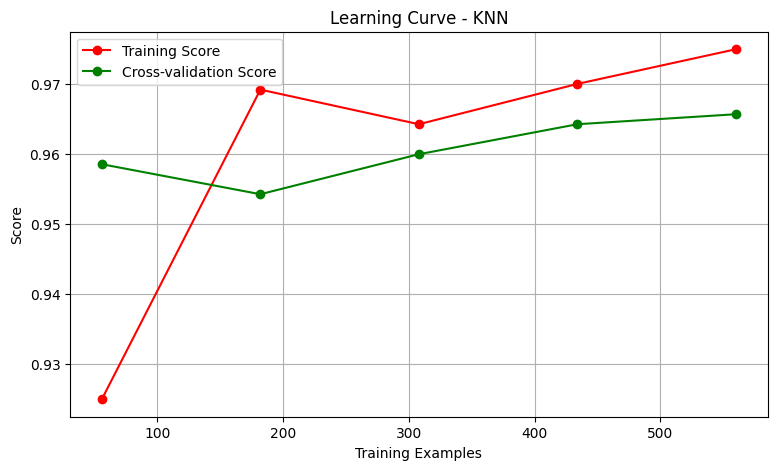

In [ ]:
# Plotting learning curves for KNN
plot_learning_curve(best_knn, 'KNN', X, y)

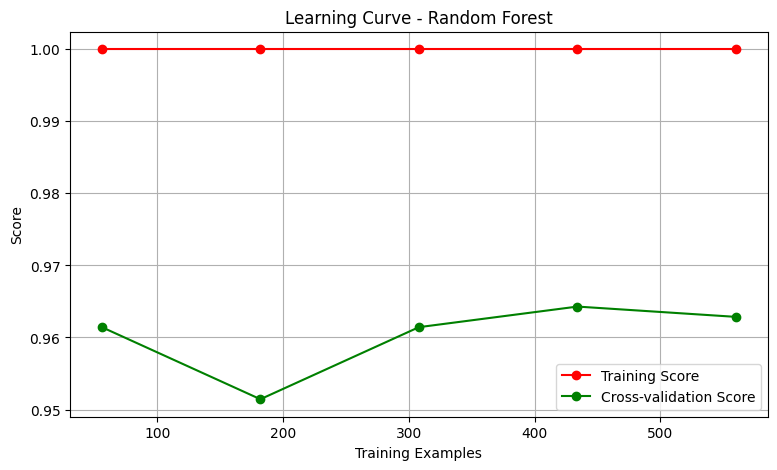

In [ ]:
# Plotting learning curves for Random Forest
plot_learning_curve(best_rf, 'Random Forest', X, y)

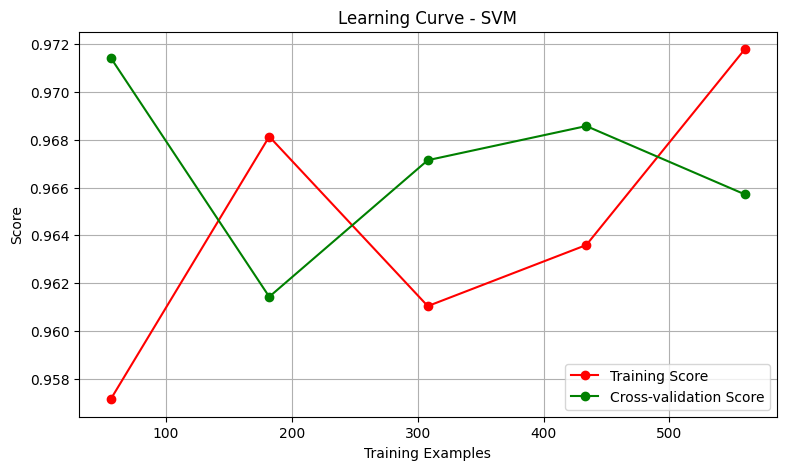

In [ ]:

# Plotting learning curves for SVM
plot_learning_curve(best_svm, 'SVM', X, y)

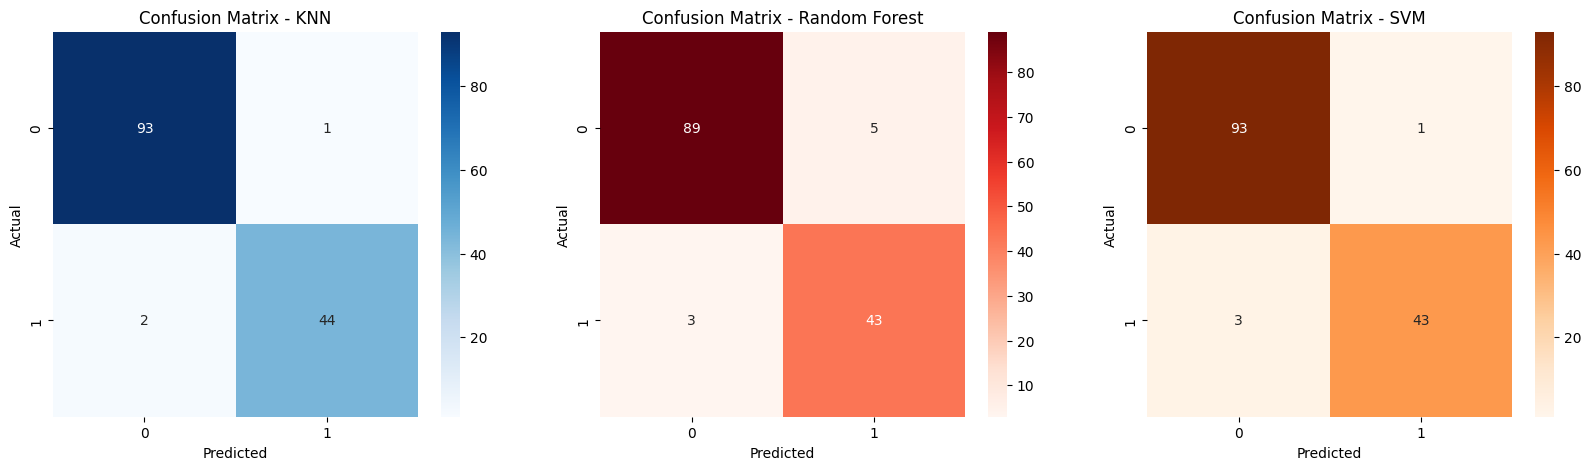

In [ ]:
# Confusion matrices
cm_knn = confusion_matrix(y_test, knn_predictions)
cm_rf = confusion_matrix(y_test, rf_predictions)
cm_svm = confusion_matrix(y_test, svm_predictions)

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_knn, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix - KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 2)
sns.heatmap(cm_rf, annot=True, cmap='Reds', fmt='g')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 3)
sns.heatmap(cm_svm, annot=True, cmap='Oranges', fmt='g')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Comparing F1 scores
best_model = None
best_f1 = 0
models = {'KNN': knn_f1, 'Random Forest': rf_f1, 'SVM': svm_f1}
for model_name, f1 in models.items():
    print(f"{model_name} F1-Score: {f1:.4f}")
    if f1 > best_f1:
        best_model = model_name
        best_f1 = f1

print(f"\nBest Model based on F1-Score: {best_model} ({best_f1:.4f} F1-Score)")


# Generates the classification report for each model
classification_reports = {}
for model_name, preds in zip(['KNN', 'Random Forest', 'SVM'], [knn_predictions, rf_predictions, svm_predictions]):
    report = classification_report(y_test, preds, output_dict=True)
    classification_reports[model_name] = pd.DataFrame(report).transpose()

# Displaying classification reports as DataFrames
for model_name, report_df in classification_reports.items():
    print(f"\nClassification Report for {model_name}:")
    display(report_df)


KNN F1-Score: 0.9785
Random Forest F1-Score: 0.9432
SVM F1-Score: 0.9713

Best Model based on F1-Score: KNN (0.9785 F1-Score)

Classification Report for KNN:


,precision,recall,f1-score,support
0,0.978947,0.989362,0.984127,94.000000
1,0.977778,0.956522,0.967033,46.000000
accuracy,0.978571,0.978571,0.978571,0.978571
macro avg,0.978363,0.972942,0.975580,140.000000
weighted avg,0.978563,0.978571,0.978510,140.000000



Classification Report for Random Forest:


,precision,recall,f1-score,support
0,0.967391,0.946809,0.956989,94.000000
1,0.895833,0.934783,0.914894,46.000000
accuracy,0.942857,0.942857,0.942857,0.942857
macro avg,0.931612,0.940796,0.935941,140.000000
weighted avg,0.943879,0.942857,0.943158,140.000000



Classification Report for SVM:


,precision,recall,f1-score,support
0,0.968750,0.989362,0.978947,94.000000
1,0.977273,0.934783,0.955556,46.000000
accuracy,0.971429,0.971429,0.971429,0.971429
macro avg,0.973011,0.962072,0.967251,140.000000
weighted avg,0.971550,0.971429,0.971261,140.000000


In [ ]:

classification_reports = {}
accuracies = {}
for model_name, preds in zip(['KNN', 'Random Forest', 'SVM'], [knn_predictions, rf_predictions, svm_predictions]):
    report = classification_report(y_test, preds, output_dict=True)
    classification_reports[model_name] = pd.DataFrame(report).transpose()
    accuracies[model_name] = accuracy_score(y_test, preds)

summary_df = pd.concat(classification_reports.values(), keys=classification_reports.keys())

summary_df = summary_df.xs('weighted avg', level=1)[['precision', 'recall', 'f1-score']]
summary_df['Accuracy'] = accuracies.values()

summary_df.columns = ['Precision', 'Recall','Accuracy', 'F1-Score']
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'level_0': 'Model'}, inplace=True)

styled_summary_df = summary_df.style.apply(lambda x: ['background-color: yellow' if v == x.max() else '' for v in x], subset=['Precision', 'Recall','Accuracy', 'F1-Score'], axis=0)

print("Summary of Classification Metrics:")
styled_summary_df


Summary of Classification Metrics:


,index,Precision,Recall,Accuracy,F1-Score
0,KNN,0.978563,0.978571,0.978510,0.978571
1,Random Forest,0.943879,0.942857,0.943158,0.942857
2,SVM,0.971550,0.971429,0.971261,0.971429
